### Sequential Testing

A common issue with classical A/B-tests, especially when you want to be able to detect small differences, is that the sample size needed can be prohibitively large. In many cases it can take several weeks, months or even years to collect enough data to conclude a test.

    * The lower number of errors we require, the larger sample size we need.
    * The smaller the difference we want to detect, the larger sample size is required.

Sequential sampling works in a very non-traditional way; instead of a fixed sample size, you choose one item (or a few) at a time, and then test your hypothesis. You can either:

    - Reject the null hypothesis (H0) in favor of the alternate hypothesis (H1) and stop,
    - Keep the null hypothesis and stop,
    - Unable to reach either conclusion with current observation and continue sampling.
    
  #### Advantage of Sequential testing
  1. Allows multiple checks on every step ensuring that error level won't exceed 5%
  2. It gives users a chance to finish experiments earlier without increasing the possibility of false result
  3. optimize necessary observation (sample size)
  4. reduce the likelihood of error
  
 ## comon Sequential testing algorithms
 
 * Sequential probability ration testing (SPRT)
 * Evan Miller Simple Sequential A/B Testing
 
 ### Evan Miller Simple Sequential A/B Testing
 
   The Evan Miller sequential procedure for one-sided test works as follows:
 
    * choose a sample size (N). Here is the link to   define N
    * Assign subjects randomly to the treatment and control, with 50% probability each.
    * Track the number of incoming successes from the treatment group. Call this number (T).
    * Track the number of incoming successes from the control group. Call this number (C).
    * If (T-C) reaches (2\sqrt{N}), stop the test. Declare the treatment to be the winner.
    * If (T+C) reaches (N), stop the test. Declare no winner.

   The two-sided test is essentially the same, but with  an alternate ending:

    * If (T-C) reaches (2.25\sqrt{N}), stop the test. Declare the treatment to be the winner.
    * If (C-T) reaches (2.25\sqrt{N}), stop the test. Declare the control to be the winner.
    * If (T+C) reaches (N), stop the test. Declare no winner.
    
  ### Sequential probability ratio testing (SPRT)

      SPRT is based on the likelihood ratio statistic.

    #### Variants of SPRT

          * Wald's(1947) sequential probability ratio test
        
          * Conditional sequential probability ratio test
       
          * Sequential Generalized Likelihood Ratio Test
       

We focus on conditional SPRT for this challenge.

#### General steps of conditional SPRT

    1. Calculate critical upper and lower decision boundaries
    2. Perform cummlative sum of the observation
    3. calculate test statistics(likelihood ration) for each of the observations
    4. calculate upper and lower limits for exposed group
    5. apply stopping


In [3]:
#importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as scs
import random
import math
import random

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../data/AdSmartABdata.csv')

In [6]:
def transform_data(df):
  '''
  segment data into exposed and control groups
  consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
  create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
  '''
  
  # Filter out users that were not interacting
  relevant_rows = df.query('yes == 1 | no == 1')
  
  # Get exposed and control groups 
  exposed = relevant_rows[relevant_rows['experiment'] == 'exposed']
  control = relevant_rows[relevant_rows['experiment'] == 'control']

  # Append hour to date for exposed group
  exposed['hour'] = exposed['hour'].astype('str')
  exposed['date_hour'] = pd.to_datetime( exposed['date'] + " " + exposed['hour'] + ":00" + ":00")
  exposed['date_hour'] = exposed['date_hour'].map( lambda x:  pd.Timestamp(x, tz=None).strftime('%Y-%m-%d:%H'))

  # Append hour to date for control group
  control['hour'] = control['hour'].astype('str')
  control['date_hour'] = pd.to_datetime(control['date'] + " " + control['hour'] + ":00" + ":00")
  control['date_hour'] = control['date_hour'].map(lambda x:  pd.Timestamp(x, tz=None).strftime('%Y-%m-%d:%H'))

  
  exposed['engagement'] = exposed['yes'] + exposed['no']
  control['engagement'] = control['yes'] + control['no']

  exposed['success'] = exposed['yes'] 
  control['success'] = control['yes'] 

  expo_p = sum(exposed['success']) / sum(exposed['engagement'])
  cont_p = sum(control['success']) / sum(control['engagement'])

  exposed_engagement = exposed['engagement'].to_numpy()
  control_engagement = control['engagement'].to_numpy()

  exposed = np.random.choice([0, 1], size=((np.sum(exposed_engagement)),), p=[expo_p, 1-expo_p])
  control = np.random.choice([0, 1], size=((np.sum(control_engagement)),), p=[cont_p , 1-cont_p ])
    
  return exposed, control

In [7]:
control, exposed = transform_data(df)
print(len(control), len(exposed))
control

657 586


array([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,

In [11]:
#checking numerical and categorical data
numerical_column = df.select_dtypes(exclude="object").columns.tolist()
categorical_column = df.select_dtypes(include="object").columns.tolist()
print("Numerical Columns:", numerical_column)
print("Categorical Columns:", categorical_column)

Numerical Columns: ['hour', 'platform_os', 'yes', 'no']
Categorical Columns: ['auction_id', 'experiment', 'date', 'device_make', 'browser']


In [12]:
user_group = df.groupby(['experiment'])
control = user_group.get_group('control')
exposed = user_group.get_group('exposed')

In [13]:
class ConditionalSPRT:
     
    def __init__(self, x, y, odd_ratio, alpha=0.05, beta=0.10, stop=None):
        self.x = x
        self.y = y
        self.odd_ratio = odd_ratio
        self.alpha = alpha
        self.beta = beta
        self.stop = stop
   
    def run(self):
        res = conditionalSPRT(self.x, self.y, self.odd_ratio,
                              self.alpha, self.beta,
                              self.stop)
        return res
    def resJson(self, res):
        outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits = res
        jsonRes = {
            "name": "Sequential AB testing",
            "outcome": outcome,
            "decsionMadeIndex": k,
            "numberOfObservation": len(n),
            "truncated": truncated,
            "truncateDecision": truncate_decision,        
      
        }
        return jsonRes
    
    def plotExperiment(self, res):
        outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits = res
        lower = limits[:, 0]
        upper = limits[:,1]

        fig, ax = plt.subplots(figsize=(12,7))

        ax.plot(n, x1, label='Cumlative value of yes+no')

        ax.plot(n, lower, label='Lower Bound', linestyle='--')
        ax.plot(n, upper, label='Upper Bound', linestyle='--')

        plt.legend()


        plt.show()

In [14]:
def conditionalSPRT(x,y,t1,alpha=0.05,beta=0.10,stop=None):
    """
    #
    # Meeker's SPRT for matched `x` (treatment) and `y` (control), 
    # both indicator responses, likelihood ratio t1, error rates alpha and beta,
    # and (optionally) truncation after trial stop.
    #
    # The return variable contains these elements:
    #(outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)
    # * outcome:   "continue," "reject null," or "accept null".
    # * n: number observation used for the decsion
    # * k:     Index at which the outcome decision was made (or NA)
    # * l:     lower critical point
    # * u:     upper critical point
    # * truncate_decision: The approximate decision made after truncate point
    # * truncated: If the test was truncated, the value of `n.0`; NA otherwise
    # * x1:       Original data `x`, cumulative
    # * r:         Cumulative sum of x+y
    # * stats:     Series of cumulative sums of log probability ratios
    # * limits:    Two rows giving lower and upper critical limits, respectively
    #
    """
    
    if t1<=1:
        print('warning',"Odd ratio should exceed 1.")
    if (alpha >0.5) | (beta >0.5):
        print('warning',"Unrealistic values of alpha or beta were passed."
                 +" You should have good reason to use large alpha & beta values")
    if stop!=None:
        stop=math.floor(n0)

    def comb(n, k):
        return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

    def lchoose(b, j):
        a=[]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            if len(j)<2:
                j=j[0]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            for k in j:
                n=b
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)
        else:
            n=b
            k=j
            if (0 <= k) & (k<= n):
                a.append(math.log(comb(n,k)))
            else:
                a.append(0)

        return np.array(a)

    def g(x,r,n,t1,t0=1):
        return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

    def h(x,r,n,t=1):
     
        return f(r,n,t,offset=ftermlog(x,r,n,t))

    def f(r,n,t,offset=0):
        upper=max(0,r-n)
        lower=min(n,r)
        rng=list(range(upper,lower+1))
        return np.sum(fterm(rng,r,n,t,offset))

    def fterm(j,r,n,t,offset=0):
        ftlog=ftermlog(j,r,n,t,offset)
        return np.array([math.exp(ex) for ex in ftlog])

    def ftermlog(j,r,n,t,offset=0):
    
        xx=r-j
        lch=lchoose(n,j)
        lchdiff=lchoose(n,xx)
        lg=np.array(j)*math.log(t)
        lgsum=lch+lchdiff
        lgsum2=lgsum+lg
        lgdiff=lgsum2-offset

        return lgdiff

    def logf(r,n,t,offset=0):
     
        z=f(r,n,t,offset)
        if z>0:
            return math.log(z)
        else:
            return np.nan

    def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
     
        offset=ftermlog(math.ceil(r/2),r,n,t1c)
        z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
        a=-math.log(alpha/(1-beta))
        b=math.log(beta/(1-alpha))
        lower=b
        upper=1+a
        return (np.array([lower,upper])+z)/math.log(t1c/t0)

    l=math.log(beta/(1-alpha))
    u=-math.log(alpha/(1-beta))
    sample_size=min(len(x),len(y))
    n=np.array(range(1,sample_size+1))

    if stop!=None:
        n=np.array([z for z in n if z<=stop])
    x1=np.cumsum(x[n-1])
    r=x1+np.cumsum(y[n-1])
    stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g
     #
      # Perform the test by finding the first index, if any, at which `stats`
      # falls outside the open interval (l, u).
      #
    clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
    limits=[]
    for v in clu:
        inArray=[]
        for vin in v:
            inArray.append(math.floor(vin))
        limits.append(np.array(inArray))
    limits=np.array(limits)

    k=np.where((stats>=u) | (stats<=l))
    cvalues=stats[k]
    if cvalues.shape[0]<1:
        k= np.nan
        outcome='Unable to conclude.Needs more sample.'
    else:
        k=np.min(k)
        if stats[k]>=u:
            outcome=f'Exposed group produced a statistically significant increase.'
        else:
            outcome='Their is no statistically significant difference between two test groups'
    if (stop!=None) & (k==np.nan):
      #
      # Truncate at trial stop, using Meeker's H0-conservative formula (2.2).
      # Leave k=NA to indicate the decision was made due to truncation.
      #
        c1=clowerUpper(r,stop,t1,alpha,beta)
        c1=math.floor(np.mean(c1)-0.5)
        if x1[n0]<=c1:
            truncate_decision='h0'
            outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
        else:
            truncate_decision='h1'
            outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
        truncated=stop
    else:
        truncate_decision='Non'
        truncated=np.nan
    return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

In [16]:
exposed_group,control_group=transform_data(df)
odd_ratio = 1.01
alpha = 0.05
beta = 0.1

In [17]:
conditionalSPRTObj = ConditionalSPRT(exposed_group,control_group, odd_ratio, alpha, beta)

In [18]:
res = conditionalSPRTObj.run()

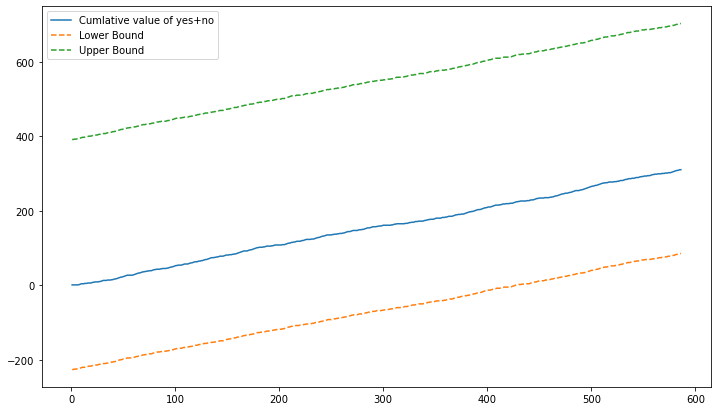

In [19]:
conditionalSPRTObj.plotExperiment(res)